# RAPIDS UMAP, Tfidf, and KMeans Discovers 15 Essay Topics
In this notebook we will find the essay topics using RAPIDS cudf, UMAP, Tfidf, and KMeans. First we will convert each text into a Tfidf embedding. Then we will use UMAP to reduce these embeddings to two dimensions. Lastly we will use KMeans to find the essay topics!

# Load RAPIDS

In [1]:
import pandas as pd, os
import cudf, cuml, cupy
from tqdm import tqdm
import numpy as np
print('RAPIDS',cudf.__version__)

ModuleNotFoundError: No module named 'cudf'

# RAPIDS cudf
We will read train text into a RAPIDS cudf.

In [ ]:
# https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533
train_names, train_texts = [], []
for f in tqdm(list(os.listdir('../input/feedback-prize-2021/train'))):
    train_names.append(f.replace('.txt', ''))
    train_texts.append(open('../input/feedback-prize-2021/train/' + f, 'r').read())
train_text_df = cudf.DataFrame({'id': train_names, 'text': train_texts})
train_text_df.head()

100%|██████████| 15594/15594 [00:45<00:00, 340.82it/s]


,id,text
0,62C57C524CD2,I think we should be able to play in a sport i...
1,80667AD3FFD8,Some schools require summer projects for stude...
2,21868C40B94F,Driverless cars have been argued and talked ab...
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu..."
4,24687D08CFDA,"Wow, from the mar really look like humans face..."


# RAPIDS Tfidf
We will use Tfidf to convert each text into a embedding vector of length 25,000.

In [ ]:
from cuml.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
text_embeddings = tfidf.fit_transform( train_text_df.text ).toarray()

# RAPIDS UMAP
We will use UMAP to reduce embedding vectors to two dimensions

In [ ]:
from cuml import UMAP
umap = UMAP()
embed_2d = umap.fit_transform(text_embeddings)
embed_2d = cupy.asnumpy( embed_2d )

# RAPIDS KMeans
We will use KMeans to find clusters of essays. These are the essay topics!

In [ ]:
from cuml import KMeans
kmeans = cuml.KMeans(n_clusters=15)
kmeans.fit(embed_2d)
train_text_df['cluster'] = kmeans.labels_

# Display Essay Topics
We will display the result of UMAP which reduced text to two dimension. We observe that the essays cluster into 15 groups. These are the 15 essay topics! Additionally we will plot the most important word from each group.

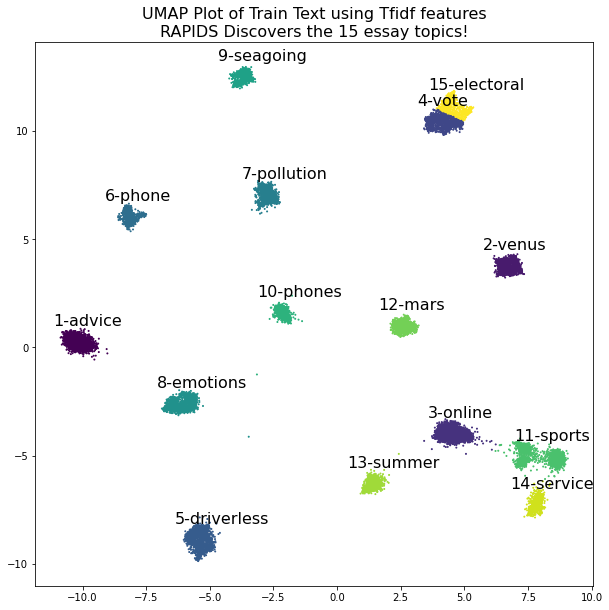

In [ ]:
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=kmeans.labels_)
plt.title('UMAP Plot of Train Text using Tfidf features\nRAPIDS Discovers the 15 essay topics!',size=16)

for k in range(len(centers)):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.argmax(mm)
    top_word = tfidf.vocabulary_.iloc[ii]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}-{top_word}',size=16)

plt.show()

# Display Example Text
We will display three example text from each essay topic. And we will display the five most important words from each topic.

In [ ]:
for k in range(15):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.asnumpy( cupy.argsort(mm)[-5:][::-1] )
    top_words = tfidf.vocabulary_.to_array()[ii]
    print('#'*25)
    print(f'### Essay Topic {k+1}')
    print('### Top 5 Words',top_words)
    print('#'*25)
    tmp = train_text_df.loc[train_text_df.cluster==k].sample(3, random_state=123)
    for j in range(3):
        txt = tmp.iloc[j,1]
        print('-'*10,f'Example {j+1}','-'*10)
        print(txt,'\n')

#########################
### Essay Topic 1
### Top 5 Words ['advice' 'multiple' 'opinions' 'ask' 'asking']
#########################
---------- Example 1 ----------
Imagine wanting something so badly, but it comes in two different colors of which you both like. Well that's where other people's opinions come into play. I can never make up my mind when I want something, because I always feel like I am going to make the wrong decision. Since I have this issue, I always find it best to ask for other people's advice. So, I can see everyone's point of view. Also, I can hear whether they do or do not enjoy it. Therefore, I will I have options with all the information I have.

First off, I play soccer, and I've been needing a new pair of cleats because my last pair had a whole in them. So, I went to Generic_Name Soccer, the store I purchase my cleats from, to look for a new pair of soccer cleats. Since my last pair was falling apart, I had to leave with a new pair of shoes. I looked at all di